In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#SBSim: A tutorial of using Reinforcement Learning for Optimizing Energy Use and Minimizing Carbon Emission in Office Buildings

___

Commercial office buildings contribute 17 percent of Carbon Emissions in the US, according to the US Energy Information Administration (EIA), and improving their efficiency will reduce their environmental burden and operating cost. A major contributor of energy consumption in these buildings are the Heating, Ventilation, and Air Conditioning (HVAC) devices. HVAC devices form a complex and interconnected thermodynamic system with the building and outside weather conditions, and current setpoint control policies are not fully optimized for minimizing energy use and carbon emission. Given a suitable training environment, a Reinforcement Learning (RL) agent is able to improve upon these policies, but training such a model, especially in a way that scales to thousands of buildings, presents many practical challenges. Most existing work on applying RL to this important task either makes use of proprietary data, or focuses on expensive and proprietary simulations that may not be grounded in the real world. We present the Smart Buildings Control Suite, the first open source interactive HVAC control dataset extracted from live sensor measurements of devices in real office buildings. The dataset consists of two components: real-world historical data from two buildings, for offline RL, and a lightweight interactive simulator for each of these buildings, calibrated using the historical data, for online and model-based RL. For ease of use, our RL environments are all compatible with the OpenAI gym environment standard. We believe this benchmark will accelerate progress and collaboration on HVAC optimization.

---

This notebook accompanies the paper titled, **Real-World Data and Calibrated Simulation Suite for Offline Training of Reinforcement Learning Agents to Optimize Energy and Emission in Office Buildings** by Judah Goldfeder and John Sipple.

#Smart Buildings Simulator Soft Actor Critic Demo

This notebook runs through training a Soft Actor Critic agent on an HVAC building simulator that has been calibrated from real world data.

In [2]:
# @title Imports
from dataclasses import dataclass
import datetime, pytz
import enum
import functools
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import time
from typing import Final, Sequence
from typing import Optional
from typing import Union, cast
os.environ['WRAPT_DISABLE_EXTENSIONS'] = 'true'
# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
from absl import logging
import gin
import gin
from matplotlib import patches
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
import reverb
import mediapy as media
from IPython.display import clear_output
import sys
sys.path.append('/home/neil/sbsim')
from smart_control.environment import environment
from smart_control.proto import smart_control_building_pb2
from smart_control.proto import smart_control_normalization_pb2
from smart_control.reward import electricity_energy_cost
from smart_control.reward import natural_gas_energy_cost
from smart_control.reward import setpoint_energy_carbon_regret
from smart_control.reward import setpoint_energy_carbon_reward
from smart_control.simulator import randomized_arrival_departure_occupancy
from smart_control.simulator import rejection_simulator_building
from smart_control.simulator import simulator_building
from smart_control.simulator import step_function_occupancy
from smart_control.simulator import stochastic_convection_simulator
from smart_control.utils import bounded_action_normalizer
from smart_control.utils import building_renderer
from smart_control.utils import controller_reader
from smart_control.utils import controller_writer
from smart_control.utils import conversion_utils
from smart_control.utils import observation_normalizer
from smart_control.utils import reader_lib
from smart_control.utils import writer_lib
from smart_control.utils import histogram_reducer
from smart_control.utils import environment_utils
import tensorflow as tf
from tf_agents.agents.sac import sac_agent
from tf_agents.agents.sac import tanh_normal_projection_network
from tf_agents.drivers import py_driver
from tf_agents.keras_layers import inner_reshape
from tf_agents.metrics import py_metrics
from tf_agents.networks import nest_map
from tf_agents.networks import sequential
from tf_agents.policies import greedy_policy
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_py_policy
from tf_agents.policies import tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.specs import tensor_spec
from tf_agents.train import actor
from tf_agents.train import actor
from tf_agents.train import learner
from tf_agents.train import triggers
from tf_agents.train.utils import spec_utils
from tf_agents.train.utils import train_utils
from tf_agents.trajectories import policy_step
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import trajectory as trajectory_lib
from tf_agents.trajectories import trajectory
from tf_agents.typing import types

In [3]:
# @title Set local runtime configurations


def logging_info(*args):
  logging.info(*args)
  print(*args)

data_path = "/home/neil/sbsim/smart_control/configs/resources/sb1/" #@param {type:"string"}
metrics_path = "/home/neil/sbsim/metrics" #@param {type:"string"}
output_data_path = '/home/neil/sbsim/output' #@param {type:"string"}
root_dir = "/home/neil/sbsim/root" #@param {type:"string"}


@gin.configurable
def get_histogram_reducer():


    reader = controller_reader.ProtoReader(data_path)

    hr = histogram_reducer.HistogramReducer(
        histogram_parameters_tuples=histogram_parameters_tuples,
        reader=reader,
        normalize_reduce=True,
        )
    return hr

!mkdir -p $root_dir
!mkdir -p $output_data_path
!mkdir -p $metrics_path




def remap_filepath(filepath) -> str:
    return filepath


In [4]:
# @title Plotting Utities
reward_shift = 0
reward_scale = 1.0
person_productivity_hour = 300.0

KELVIN_TO_CELSIUS = 273.15


def render_env(env: environment.Environment):
  """Renders the environment."""
  building_layout = env.building._simulator._building._floor_plan

  # create a renderer
  renderer = building_renderer.BuildingRenderer(building_layout, 1)

  # get the current temps to render
  # this also is not ideal, since the temps are not fully exposed.
  # V Ideally this should be a publicly accessable field
  temps = env.building._simulator._building.temp

  input_q = env.building._simulator._building.input_q

  # render
  vmin = 285
  vmax = 305
  image = renderer.render(
      temps,
      cmap='bwr',
      vmin=vmin,
      vmax=vmax,
      colorbar=False,
      input_q=input_q,
      diff_range=0.5,
      diff_size=1,
  ).convert('RGB')
  media.show_image(
      image, title='Environment %s' % env.current_simulation_timestamp
  )


def get_energy_timeseries(reward_infos, time_zone: str) -> pd.DataFrame:
  """Returns a timeseries of energy rates."""

  start_times = []
  end_times = []

  device_ids = []
  device_types = []
  air_handler_blower_electrical_energy_rates = []
  air_handler_air_conditioner_energy_rates = []
  boiler_natural_gas_heating_energy_rates = []
  boiler_pump_electrical_energy_rates = []

  for reward_info in reward_infos:
    end_timestamp = conversion_utils.proto_to_pandas_timestamp(
        reward_info.end_timestamp
    ).tz_convert(time_zone)
    start_timestamp = end_timestamp - pd.Timedelta(300, unit='second')

    for air_handler_id in reward_info.air_handler_reward_infos:
      start_times.append(start_timestamp)
      end_times.append(end_timestamp)

      device_ids.append(air_handler_id)
      device_types.append('air_handler')

      air_handler_blower_electrical_energy_rates.append(
          reward_info.air_handler_reward_infos[
              air_handler_id
          ].blower_electrical_energy_rate
      )
      air_handler_air_conditioner_energy_rates.append(
          reward_info.air_handler_reward_infos[
              air_handler_id
          ].air_conditioning_electrical_energy_rate
      )
      boiler_natural_gas_heating_energy_rates.append(0)
      boiler_pump_electrical_energy_rates.append(0)

    for boiler_id in reward_info.boiler_reward_infos:
      start_times.append(start_timestamp)
      end_times.append(end_timestamp)

      device_ids.append(boiler_id)
      device_types.append('boiler')

      air_handler_blower_electrical_energy_rates.append(0)
      air_handler_air_conditioner_energy_rates.append(0)

      boiler_natural_gas_heating_energy_rates.append(
          reward_info.boiler_reward_infos[
              boiler_id
          ].natural_gas_heating_energy_rate
      )
      boiler_pump_electrical_energy_rates.append(
          reward_info.boiler_reward_infos[boiler_id].pump_electrical_energy_rate
      )

  df_map = {
      'start_time': start_times,
      'end_time': end_times,
      'device_id': device_ids,
      'device_type': device_types,
      'air_handler_blower_electrical_energy_rate': (
          air_handler_blower_electrical_energy_rates
      ),
      'air_handler_air_conditioner_energy_rate': (
          air_handler_air_conditioner_energy_rates
      ),
      'boiler_natural_gas_heating_energy_rate': (
          boiler_natural_gas_heating_energy_rates
      ),
      'boiler_pump_electrical_energy_rate': boiler_pump_electrical_energy_rates,
  }
  df = pd.DataFrame(df_map).sort_values('start_time')
  return df


def get_outside_air_temperature_timeseries(
    observation_responses,
    time_zone: str,
) -> pd.Series:
  """Returns a timeseries of outside air temperature."""
  temps = []
  for i in range(len(observation_responses)):
    temp = [
        (
            conversion_utils.proto_to_pandas_timestamp(
                sor.timestamp
            ).tz_convert(time_zone)
            - pd.Timedelta(300, unit='second'),
            sor.continuous_value,
        )
        for sor in observation_responses[i].single_observation_responses
        if sor.single_observation_request.measurement_name
        == 'outside_air_temperature_sensor'
    ][0]
    temps.append(temp)

  res = list(zip(*temps))
  return pd.Series(res[1], index=res[0]).sort_index()


def get_reward_timeseries(
    reward_infos,
    reward_responses,
    time_zone: str,
) -> pd.DataFrame:
  """Returns a timeseries of reward values."""
  cols = [
      'agent_reward_value',
      'electricity_energy_cost',
      'carbon_emitted',
      'occupancy',
  ]
  df = pd.DataFrame(columns=cols)

  for i in range(min(len(reward_responses), len(reward_infos))):
    step_start_timestamp = conversion_utils.proto_to_pandas_timestamp(
        reward_infos[i].start_timestamp
    ).tz_convert(time_zone)
    step_end_timestamp = conversion_utils.proto_to_pandas_timestamp(
        reward_infos[i].end_timestamp
    ).tz_convert(time_zone)
    delta_time_sec = (step_end_timestamp - step_start_timestamp).total_seconds()
    occupancy = np.sum([
        reward_infos[i].zone_reward_infos[zone_id].average_occupancy
        for zone_id in reward_infos[i].zone_reward_infos
    ])

    df.loc[
        conversion_utils.proto_to_pandas_timestamp(
            reward_infos[i].start_timestamp
        ).tz_convert(time_zone)
    ] = [
        reward_responses[i].agent_reward_value,
        reward_responses[i].electricity_energy_cost,
        reward_responses[i].carbon_emitted,
        occupancy,
    ]

  df = df.sort_index()
  df['cumulative_reward'] = df['agent_reward_value'].cumsum()
  logging_info('Cumulative reward: %4.2f' % df.iloc[-1]['cumulative_reward'])
  return df


def format_plot(
    ax1, xlabel: str, start_time: int, end_time: int, time_zone: str
):
  """Formats a plot with common attributes."""
  ax1.set_facecolor('black')
  ax1.xaxis.tick_top()
  ax1.tick_params(axis='x', labelsize=12)
  ax1.tick_params(axis='y', labelsize=12)
  ax1.xaxis.set_major_formatter(
      mdates.DateFormatter('%a %m/%d %H:%M', tz=pytz.timezone(time_zone))
  )
  ax1.grid(color='gray', linestyle='-', linewidth=1.0)
  ax1.set_ylabel(xlabel, color='blue', fontsize=12)
  ax1.set_xlim(left=start_time, right=end_time)
  ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.legend(prop={'size': 10})


def plot_occupancy_timeline(
    ax1, reward_timeseries: pd.DataFrame, time_zone: str
):
  local_times = [ts.tz_convert(time_zone) for ts in reward_timeseries.index]
  ax1.plot(
      local_times,
      reward_timeseries['occupancy'],
      color='cyan',
      marker=None,
      alpha=1,
      lw=2,
      linestyle='-',
      label='Num Occupants',
  )
  format_plot(
      ax1,
      'Occupancy',
      reward_timeseries.index.min(),
      reward_timeseries.index.max(),
      time_zone,
  )


def plot_energy_cost_timeline(
    ax1,
    reward_timeseries: pd.DataFrame,
    time_zone: str,
    cumulative: bool = False,
):
  local_times = [ts.tz_convert(time_zone) for ts in reward_timeseries.index]
  if cumulative:
    feature_timeseries_cost = reward_timeseries[
        'electricity_energy_cost'
    ].cumsum()
  else:
    feature_timeseries_cost = reward_timeseries['electricity_energy_cost']
  ax1.plot(
      local_times,
      feature_timeseries_cost,
      color='magenta',
      marker=None,
      alpha=1,
      lw=2,
      linestyle='-',
      label='Electricity',
  )

  format_plot(
      ax1,
      'Energy Cost [$]',
      reward_timeseries.index.min(),
      reward_timeseries.index.max(),
      time_zone,
  )


def plot_reward_timeline(ax1, reward_timeseries, time_zone):

  local_times = [ts.tz_convert(time_zone) for ts in reward_timeseries.index]

  ax1.plot(
      local_times,
      reward_timeseries['cumulative_reward'],
      color='royalblue',
      marker=None,
      alpha=1,
      lw=6,
      linestyle='-',
      label='reward',
  )
  format_plot(
      ax1,
      'Agent Reward',
      reward_timeseries.index.min(),
      reward_timeseries.index.max(),
      time_zone,
  )


def plot_energy_timeline(ax1, energy_timeseries, time_zone, cumulative=False):

  def _to_kwh(
      energy_rate: float,
      step_interval: pd.Timedelta = pd.Timedelta(5, unit='minute'),
  ) -> float:
    kw_power = energy_rate / 1000.0
    hwh_power = kw_power * step_interval / pd.Timedelta(1, unit='hour')
    return hwh_power.cumsum()

  timeseries = energy_timeseries[
      energy_timeseries['device_type'] == 'air_handler'
  ]

  if cumulative:
    feature_timeseries_ac = _to_kwh(
        timeseries['air_handler_air_conditioner_energy_rate']
    )
    feature_timeseries_blower = _to_kwh(
        timeseries['air_handler_blower_electrical_energy_rate']
    )
  else:
    feature_timeseries_ac = (
        timeseries['air_handler_air_conditioner_energy_rate'] / 1000.0
    )
    feature_timeseries_blower = (
        timeseries['air_handler_blower_electrical_energy_rate'] / 1000.0
    )

  ax1.plot(
      timeseries['start_time'],
      feature_timeseries_ac,
      color='magenta',
      marker=None,
      alpha=1,
      lw=4,
      linestyle='-',
      label='AHU Electricity',
  )
  ax1.plot(
      timeseries['start_time'],
      feature_timeseries_blower,
      color='magenta',
      marker=None,
      alpha=1,
      lw=4,
      linestyle='--',
      label='FAN Electricity',
  )

  timeseries = energy_timeseries[energy_timeseries['device_type'] == 'boiler']
  if cumulative:
    feature_timeseries_gas = _to_kwh(
        timeseries['boiler_natural_gas_heating_energy_rate']
    )
    feature_timeseries_pump = _to_kwh(
        timeseries['boiler_pump_electrical_energy_rate']
    )
  else:
    feature_timeseries_gas = (
        timeseries['boiler_natural_gas_heating_energy_rate'] / 1000.0
    )
    feature_timeseries_pump = (
        timeseries['boiler_pump_electrical_energy_rate'] / 1000.0
    )

  ax1.plot(
      timeseries['start_time'],
      feature_timeseries_gas,
      color='lime',
      marker=None,
      alpha=1,
      lw=4,
      linestyle='-',
      label='BLR Gas',
  )
  ax1.plot(
      timeseries['start_time'],
      feature_timeseries_pump,
      color='lime',
      marker=None,
      alpha=1,
      lw=4,
      linestyle='--',
      label='Pump Electricity',
  )

  if cumulative:
    label = 'HVAC Energy Consumption [kWh]'
  else:
    label = 'HVAC Power Consumption [kW]'

  format_plot(
      ax1,
      label,
      timeseries['start_time'].min(),
      timeseries['end_time'].max(),
      time_zone,
  )


def plot_carbon_timeline(ax1, reward_timeseries, time_zone, cumulative=False):
  """Plots carbon-emission timeline."""

  if cumulative:
    feature_timeseries_carbon = reward_timeseries['carbon_emitted'].cumsum()
  else:
    feature_timeseries_carbon = reward_timeseries['carbon_emitted']
  ax1.plot(
      reward_timeseries.index,
      feature_timeseries_carbon,
      color='white',
      marker=None,
      alpha=1,
      lw=4,
      linestyle='-',
      label='Carbon',
  )
  format_plot(
      ax1,
      'Carbon emission [kg]',
      reward_timeseries.index.min(),
      reward_timeseries.index.max(),
      time_zone,
  )


def get_zone_timeseries(reward_infos, time_zone):
  """Converts reward infos to a timeseries dataframe."""

  start_times = []
  end_times = []
  zones = []
  heating_setpoints = []
  cooling_setpoints = []
  zone_air_temperatures = []
  air_flow_rate_setpoints = []
  air_flow_rates = []
  average_occupancies = []

  for reward_info in reward_infos:
    start_timestamp = conversion_utils.proto_to_pandas_timestamp(
        reward_info.end_timestamp
    ).tz_convert(time_zone) - pd.Timedelta(300, unit='second')
    end_timestamp = conversion_utils.proto_to_pandas_timestamp(
        reward_info.end_timestamp
    ).tz_convert(time_zone)

    for zone_id in reward_info.zone_reward_infos:
      zones.append(zone_id)
      start_times.append(start_timestamp)
      end_times.append(end_timestamp)

      heating_setpoints.append(
          reward_info.zone_reward_infos[zone_id].heating_setpoint_temperature
      )
      cooling_setpoints.append(
          reward_info.zone_reward_infos[zone_id].cooling_setpoint_temperature
      )

      zone_air_temperatures.append(
          reward_info.zone_reward_infos[zone_id].zone_air_temperature
      )
      air_flow_rate_setpoints.append(
          reward_info.zone_reward_infos[zone_id].air_flow_rate_setpoint
      )
      air_flow_rates.append(
          reward_info.zone_reward_infos[zone_id].air_flow_rate
      )
      average_occupancies.append(
          reward_info.zone_reward_infos[zone_id].average_occupancy
      )

  df_map = {
      'start_time': start_times,
      'end_time': end_times,
      'zone': zones,
      'heating_setpoint_temperature': heating_setpoints,
      'cooling_setpoint_temperature': cooling_setpoints,
      'zone_air_temperature': zone_air_temperatures,
      'air_flow_rate_setpoint': air_flow_rate_setpoints,
      'air_flow_rate': air_flow_rates,
      'average_occupancy': average_occupancies,
  }
  return pd.DataFrame(df_map).sort_values('start_time')


def get_action_timeseries(action_responses):
  """Converts action responses to a dataframe."""
  timestamps = []
  device_ids = []
  setpoint_names = []
  setpoint_values = []
  response_types = []
  for action_response in action_responses:

    timestamp = conversion_utils.proto_to_pandas_timestamp(
        action_response.timestamp
    )
    for single_action_response in action_response.single_action_responses:
      device_id = single_action_response.request.device_id
      setpoint_name = single_action_response.request.setpoint_name
      setpoint_value = single_action_response.request.continuous_value
      response_type = single_action_response.response_type

      timestamps.append(timestamp)
      device_ids.append(device_id)
      setpoint_names.append(setpoint_name)
      setpoint_values.append(setpoint_value)
      response_types.append(response_type)

  return pd.DataFrame({
      'timestamp': timestamps,
      'device_id': device_ids,
      'setpoint_name': setpoint_names,
      'setpoint_value': setpoint_values,
      'response_type': response_types,
  })


def plot_action_timeline(ax1, action_timeseries, action_tuple, time_zone):
  """Plots action timeline."""

  single_action_timeseries = action_timeseries[
      (action_timeseries['device_id'] == action_tuple[0])
      & (action_timeseries['setpoint_name'] == action_tuple[1])
  ]
  single_action_timeseries = single_action_timeseries.sort_values(
      by='timestamp'
  )

  if action_tuple[1] in [
      'supply_water_setpoint',
      'supply_air_heating_temperature_setpoint',
  ]:
    single_action_timeseries['setpoint_value'] = (
        single_action_timeseries['setpoint_value'] - KELVIN_TO_CELSIUS
    )

  ax1.plot(
      single_action_timeseries['timestamp'],
      single_action_timeseries['setpoint_value'],
      color='lime',
      marker=None,
      alpha=1,
      lw=4,
      linestyle='-',
      label=action_tuple[1],
  )
  title = '%s %s' % (action_tuple[0], action_tuple[1])
  format_plot(
      ax1,
      'Action',
      single_action_timeseries['timestamp'].min(),
      single_action_timeseries['timestamp'].max(),
      time_zone,
  )


def get_outside_air_temperature_timeseries(observation_responses, time_zone):
  temps = []
  for i in range(len(observation_responses)):
    temp = [
        (
            conversion_utils.proto_to_pandas_timestamp(
                sor.timestamp
            ).tz_convert(time_zone),
            sor.continuous_value,
        )
        for sor in observation_responses[i].single_observation_responses
        if sor.single_observation_request.measurement_name
        == 'outside_air_temperature_sensor'
    ][0]
    temps.append(temp)

  res = list(zip(*temps))
  return pd.Series(res[1], index=res[0]).sort_index()


def plot_temperature_timeline(
    ax1, zone_timeseries, outside_air_temperature_timeseries, time_zone
):
  zone_temps = pd.pivot_table(
      zone_timeseries,
      index=zone_timeseries['start_time'],
      columns='zone',
      values='zone_air_temperature',
  ).sort_index()
  zone_temps.quantile(q=0.25, axis=1)
  zone_temp_stats = pd.DataFrame({
      'min_temp': zone_temps.min(axis=1),
      'q25_temp': zone_temps.quantile(q=0.25, axis=1),
      'median_temp': zone_temps.median(axis=1),
      'q75_temp': zone_temps.quantile(q=0.75, axis=1),
      'max_temp': zone_temps.max(axis=1),
  })

  zone_heating_setpoints = (
      pd.pivot_table(
          zone_timeseries,
          index=zone_timeseries['start_time'],
          columns='zone',
          values='heating_setpoint_temperature',
      )
      .sort_index()
      .min(axis=1)
  )
  zone_cooling_setpoints = (
      pd.pivot_table(
          zone_timeseries,
          index=zone_timeseries['start_time'],
          columns='zone',
          values='cooling_setpoint_temperature',
      )
      .sort_index()
      .max(axis=1)
  )

  ax1.plot(
      zone_cooling_setpoints.index,
      zone_cooling_setpoints - KELVIN_TO_CELSIUS,
      color='yellow',
      lw=1,
  )
  ax1.plot(
      zone_cooling_setpoints.index,
      zone_heating_setpoints - KELVIN_TO_CELSIUS,
      color='yellow',
      lw=1,
  )

  ax1.fill_between(
      zone_temp_stats.index,
      zone_temp_stats['min_temp'] - KELVIN_TO_CELSIUS,
      zone_temp_stats['max_temp'] - KELVIN_TO_CELSIUS,
      facecolor='green',
      alpha=0.8,
  )
  ax1.fill_between(
      zone_temp_stats.index,
      zone_temp_stats['q25_temp'] - KELVIN_TO_CELSIUS,
      zone_temp_stats['q75_temp'] - KELVIN_TO_CELSIUS,
      facecolor='green',
      alpha=0.8,
  )
  ax1.plot(
      zone_temp_stats.index,
      zone_temp_stats['median_temp'] - KELVIN_TO_CELSIUS,
      color='white',
      lw=3,
      alpha=1.0,
  )
  ax1.plot(
      outside_air_temperature_timeseries.index,
      outside_air_temperature_timeseries - KELVIN_TO_CELSIUS,
      color='magenta',
      lw=3,
      alpha=1.0,
  )
  format_plot(
      ax1,
      'Temperature [C]',
      zone_temp_stats.index.min(),
      zone_temp_stats.index.max(),
      time_zone,
  )


def plot_timeseries_charts(reader, time_zone):
  """Plots timeseries charts."""

  observation_responses = reader.read_observation_responses(
      pd.Timestamp.min, pd.Timestamp.max
  )
  action_responses = reader.read_action_responses(
      pd.Timestamp.min, pd.Timestamp.max
  )
  reward_infos = reader.read_reward_infos(pd.Timestamp.min, pd.Timestamp.max)
  reward_responses = reader.read_reward_responses(
      pd.Timestamp.min, pd.Timestamp.max
  )

  if len(reward_infos) == 0 or len(reward_responses) == 0:
    return

  action_timeseries = get_action_timeseries(action_responses)
  action_tuples = list(
      set([
          (row['device_id'], row['setpoint_name'])
          for _, row in action_timeseries.iterrows()
      ])
  )

  reward_timeseries = get_reward_timeseries(
      reward_infos, reward_responses, time_zone
  ).sort_index()
  outside_air_temperature_timeseries = get_outside_air_temperature_timeseries(
      observation_responses, time_zone
  )
  zone_timeseries = get_zone_timeseries(reward_infos, time_zone)
  fig, axes = plt.subplots(
      nrows=6 + len(action_tuples),
      ncols=1,
      gridspec_kw={
          'height_ratios': [1, 1, 1, 1, 1, 1] + [1] * len(action_tuples)
      },
      squeeze=True,
  )
  fig.set_size_inches(24, 25)

  energy_timeseries = get_energy_timeseries(reward_infos, time_zone)
  plot_reward_timeline(axes[0], reward_timeseries, time_zone)
  plot_energy_timeline(axes[1], energy_timeseries, time_zone, cumulative=True)
  plot_energy_cost_timeline(
      axes[2], reward_timeseries, time_zone, cumulative=True
  )
  plot_carbon_timeline(axes[3], reward_timeseries, time_zone, cumulative=True)
  plot_occupancy_timeline(axes[4], reward_timeseries, time_zone)
  plot_temperature_timeline(
      axes[5], zone_timeseries, outside_air_temperature_timeseries, time_zone
  )

  for i, action_tuple in enumerate(action_tuples):
    plot_action_timeline(
        axes[6 + i], action_timeseries, action_tuple, time_zone
    )

  plt.show()

# Load up the environment

In this section we load up the Smart Buildings simulator environment.

In [5]:
# @title Utils for importing the environment.

def load_environment(gin_config_file: str):
  """Returns an Environment from a config file."""
  # Global definition is required by Gin library to instantiate Environment.
  global environment  # pylint: disable=global-variable-not-assigned
  with gin.unlock_config():
    gin.parse_config_file(gin_config_file)
    return environment.Environment()  # pylint: disable=no-value-for-parameter


def get_latest_episode_reader(
    metrics_path: str,
) -> controller_reader.ProtoReader:

  episode_infos = controller_reader.get_episode_data(metrics_path).sort_index()
  selected_episode = episode_infos.index[-1]
  episode_path = os.path.join(metrics_path, selected_episode)
  reader = controller_reader.ProtoReader(episode_path)
  return reader

@gin.configurable
def get_histogram_path():
  return data_path


@gin.configurable
def get_reset_temp_values():
  reset_temps_filepath = remap_filepath(
      os.path.join(data_path, "reset_temps.npy")
  )

  return np.load(reset_temps_filepath)


@gin.configurable
def get_zone_path():
  return remap_filepath(
      os.path.join(data_path, "double_resolution_zone_1_2.npy")
  )


@gin.configurable
def get_metrics_path():
  return os.path.join(metrics_path, "metrics")


@gin.configurable
def get_weather_path():
  return remap_filepath(
      os.path.join(
          data_path, "local_weather_moffett_field_20230701_20231122.csv"
      )
  )

In the cell below, we will load the collect and eval environments. While we are loading the same environment, below, it would be useful to load the same building over near, but non-overlapping time windows.

In [6]:
# @title Load the environments

histogram_parameters_tuples = (
        ('zone_air_temperature_sensor',(285., 286., 287., 288, 289., 290., 291., 292., 293., 294., 295., 296., 297., 298., 299., 300.,301,302,303)),
        ('supply_air_damper_percentage_command',(0.0, 0.2, 0.4, 0.6, 0.8, 1.0)),
        ('supply_air_flowrate_setpoint',( 0., 0.05, .1, .2, .3, .4, .5,  .7,  .9)),
    )

time_zone = 'US/Pacific'
collect_scenario_config = os.path.join(data_path, "sim_config.gin")
print(collect_scenario_config)
eval_scenario_config = os.path.join(data_path, "sim_config.gin")
print(eval_scenario_config)

collect_env = load_environment(collect_scenario_config)

# For efficency, set metrics_path to None
collect_env._metrics_path = None
collect_env._occupancy_normalization_constant = 125.0

eval_env = load_environment(eval_scenario_config)
# eval_env._label += "_eval"
eval_env._metrics_path = metrics_path
eval_env._occupancy_normalization_constant = 125.0

initial_collect_env = load_environment(eval_scenario_config)

initial_collect_env._metrics_path = metrics_path
initial_collect_env._occupancy_normalization_constant = 125.0

/home/neil/sbsim/smart_control/configs/resources/sb1/sim_config.gin
/home/neil/sbsim/smart_control/configs/resources/sb1/sim_config.gin


In the section below, we'll define a function that accepts the envirnment and a policy, and runs a fixed number of episodes. The policy can be a rules-based policy or an RL-based policy.

In [7]:
# @title Define a method to execute the policy on the environment.


def get_trajectory(time_step, current_action: policy_step.PolicyStep):
  """Get the trajectory for the current action and time step."""
  observation = time_step.observation
  action = current_action.action
  policy_info = ()
  reward = time_step.reward
  discount = time_step.discount

  if time_step.is_first():
    traj = trajectory.first(observation, action, policy_info, reward, discount)

  elif time_step.is_last():
    traj = trajectory.last(observation, action, policy_info, reward, discount)

  else:
    traj = trajectory.mid(observation, action, policy_info, reward, discount)
  return traj


def compute_avg_return(
    environment,
    policy,
    num_episodes=1,
    time_zone: str = "US/Pacific",
    render_interval_steps: int = 24,
    trajectory_observers=None,
):
  """Computes the average return of the policy on the environment.

  Args:
    environment: environment.Environment
    policy: policy.Policy
    num_episodes: total number of eposides to run.
    time_zone: time zone of the environment
    render_interval_steps: Number of steps to take between rendering.
    trajectory_observers: list of trajectory observers for use in rendering.
  """

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()

    episode_return = 0.0
    t0 = time.time()
    epoch = t0

    step_id = 0
    execution_times = []

    while not time_step.is_last():

      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)

      if trajectory_observers is not None:
        traj = get_trajectory(time_step, action_step)
        for observer in trajectory_observers:
          observer(traj)

      episode_return += time_step.reward
      t1 = time.time()
      dt = t1 - t0
      episode_seconds = t1 - epoch
      execution_times.append(dt)
      sim_time = environment.current_simulation_timestamp.tz_convert(time_zone)

      print(
          "Step %5d Sim Time: %s, Reward: %8.2f, Return: %8.2f, Mean Step Time:"
          " %8.2f s, Episode Time: %8.2f s"
          % (
              step_id,
              sim_time.strftime("%Y-%m-%d %H:%M"),
              time_step.reward,
              episode_return,
              np.mean(execution_times),
              episode_seconds,
          )
      )

      if (step_id > 0) and (step_id % render_interval_steps == 0):
        if environment._metrics_path:
          clear_output(wait=True)
          reader = get_latest_episode_reader(environment._metrics_path)
          plot_timeseries_charts(reader, time_zone)
        render_env(environment)

      t0 = t1
      step_id += 1
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return

# Rules-based Control (RBC)

In [8]:
# @title Utils for RBC

# We're concerned with controlling Heatpumps/ACs and Hot Water Systems (HWS).
class DeviceType(enum.Enum):
  AC = 0
  HWS = 1


SetpointName = str  # Identify the setpoint
# Setpoint value.
SetpointValue = Union[float, int, bool]


@dataclass
class ScheduleEvent:
  start_time: pd.Timedelta
  device: DeviceType
  setpoint_name: SetpointName
  setpoint_value: SetpointValue


# A schedule is a list of times and setpoints for a device.
Schedule = list[ScheduleEvent]
ActionSequence = list[tuple[DeviceType, SetpointName]]


def to_rad(sin_theta: float, cos_theta: float) -> float:
  """Converts a sin and cos theta to radians to extract the time."""

  if sin_theta >= 0 and cos_theta >= 0:
    return np.arccos(cos_theta)
  elif sin_theta >= 0 and cos_theta < 0:
    return np.pi - np.arcsin(sin_theta)
  elif sin_theta < 0 and cos_theta < 0:
    return np.pi - np.arcsin(sin_theta)
  else:
    return 2 * np.pi - np.arccos(cos_theta)

  return np.arccos(cos_theta) + rad_offset


def to_dow(sin_theta: float, cos_theta: float) -> float:
  """Converts a sin and cos theta to days to extract day of week."""
  theta = to_rad(sin_theta, cos_theta)
  return np.floor(7 * theta / 2 / np.pi)


def to_hod(sin_theta: float, cos_theta: float) -> float:
  """Converts a sin and cos theta to hours to extract hour of day."""
  theta = to_rad(sin_theta, cos_theta)
  return np.floor(24 * theta / 2 / np.pi)


def find_schedule_action(
    schedule: Schedule,
    device: DeviceType,
    setpoint_name: SetpointName,
    timestamp: pd.Timedelta,
) -> SetpointValue:
  """Finds the action for a schedule event for a time and schedule."""

  # Get all the schedule events for the device and the setpoint, and turn it
  # into a series.
  device_schedule_dict = {}
  for schedule_event in schedule:
    if (
        schedule_event.device == device
        and schedule_event.setpoint_name == setpoint_name
    ):
      device_schedule_dict[schedule_event.start_time] = (
          schedule_event.setpoint_value
      )
  device_schedule = pd.Series(device_schedule_dict)

  # Get the indexes of the schedule events that fall before the timestamp.

  device_schedule_indexes = device_schedule.index[
      device_schedule.index <= timestamp
  ]

  # If are no events preceedding the time, then choose the last
  # (assuming it wraps around).
  if device_schedule_indexes.empty:
    return device_schedule.loc[device_schedule.index[-1]]
  else:
    return device_schedule.loc[device_schedule_indexes[-1]]

In [9]:
# @title Define a schedule policy

class SchedulePolicy(tf_policy.TFPolicy):
  """TF Policy implementation of the Schedule policy."""

  def __init__(
      self,
      time_step_spec,
      action_spec: types.NestedTensorSpec,
      action_sequence: ActionSequence,
      weekday_schedule_events: Schedule,
      weekend_holiday_schedule_events: Schedule,
      dow_sin_index: int,
      dow_cos_index: int,
      hod_sin_index: int,
      hod_cos_index: int,
      action_normalizers,
      local_start_time: str = pd.Timestamp,
      policy_state_spec: types.NestedTensorSpec = (),
      info_spec: types.NestedTensorSpec = (),
      training: bool = False,
      name: Optional[str] = None,
  ):
    self.weekday_schedule_events = weekday_schedule_events
    self.weekend_holiday_schedule_events = weekend_holiday_schedule_events
    self.dow_sin_index = dow_sin_index
    self.dow_cos_index = dow_cos_index
    self.hod_sin_index = hod_sin_index
    self.hod_cos_index = hod_cos_index
    self.action_sequence = action_sequence
    self.action_normalizers = action_normalizers
    self.local_start_time = local_start_time
    self.norm_mean = 0.0
    self.norm_std = 1.0

    policy_state_spec = ()

    super().__init__(
        time_step_spec=time_step_spec,
        action_spec=action_spec,
        policy_state_spec=policy_state_spec,
        info_spec=info_spec,
        clip=False,
        observation_and_action_constraint_splitter=None,
        name=name,
    )

  def _normalize_action_map(
      self, action_map: dict[tuple[DeviceType, SetpointName], SetpointValue]
  ) -> dict[tuple[DeviceType, SetpointName], SetpointValue]:

    normalized_action_map = {}

    for k, v in action_map.items():
      for normalizer_k, normalizer in self.action_normalizers.items():
        if normalizer_k.endswith(k[1]):

          normed_v = normalizer.agent_value(v)
          normalized_action_map[k] = normed_v

    return normalized_action_map

  def _get_action(
      self, time_step
  ) -> dict[tuple[DeviceType, SetpointName], SetpointValue]:

    observation = time_step.observation
    action_spec = cast(tensor_spec.BoundedTensorSpec, self.action_spec)
    dow_sin = (observation[self.dow_sin_index] * self.norm_std) + self.norm_mean
    dow_cos = (observation[self.dow_cos_index] * self.norm_std) + self.norm_mean
    hod_sin = (observation[self.hod_sin_index] * self.norm_std) + self.norm_mean
    hod_cos = (observation[self.hod_cos_index] * self.norm_std) + self.norm_mean

    dow = to_dow(dow_sin, dow_cos)
    hod = to_hod(hod_sin, hod_cos)

    timestamp = (
        pd.Timedelta(hod, unit='hour') + self.local_start_time.utcoffset()
    )

    if dow < 5:  # weekday

      action_map = {
          (tup[0], tup[1]): find_schedule_action(
              self.weekday_schedule_events, tup[0], tup[1], timestamp
          )
          for tup in action_sequence
      }

      return action_map

    else:  # Weekend

      action_map = {
          (tup[0], tup[1]): find_schedule_action(
              self.weekend_holiday_schedule_events, tup[0], tup[1], timestamp
          )
          for tup in action_sequence
      }

      return action_map

  def _action(self, time_step, policy_state, seed):
    del seed
    action_map = self._get_action(time_step)
    normalized_action_map = self._normalize_action_map(action_map)

    action = np.array(
        [
            normalized_action_map[device_setpoint]
            for device_setpoint in action_sequence
        ],
        dtype=np.float32,
    )

    t_action = tf.convert_to_tensor(action)
    return policy_step.PolicyStep(t_action, (), ())

Next, we parameterize the setpoint schedule.

We distinguish between weekend and holiday schedules:

* For **weekdays, between 6:00 am and 7:00 pm local time** we maintain occupancy conditions:
  * AC/Heatpump supply air heating setpoint is 12 C
  * Supply water temperarure is 77 C
* For **weekday, before 6:00 am and after 7:00 pm locl time** we maintain efficiency conditions (setback):
  * AC/Heatpump supply air heating setpoint is 0 C
  * Supply water temperarure is 42 C

* For **weekends and holdidays**, all day, we maintain efficiency conditions (setback):
  * AC/Heatpump supply air heating setpoint is 0 C
  * Supply water temperarure is 42 C


In [10]:
# @title Configure the schedule parameters

hod_cos_index = collect_env._field_names.index('hod_cos_000')
hod_sin_index = collect_env._field_names.index('hod_sin_000')
dow_cos_index = collect_env._field_names.index('dow_cos_000')
dow_sin_index = collect_env._field_names.index('dow_sin_000')


# Note that temperatures are specified in Kelvin:
weekday_schedule_events = [
    ScheduleEvent(
        pd.Timedelta(6, unit='hour'),
        DeviceType.AC,
        'supply_air_heating_temperature_setpoint',
        292.0,
    ),
    ScheduleEvent(
        pd.Timedelta(19, unit='hour'),
        DeviceType.AC,
        'supply_air_heating_temperature_setpoint',
        285.0,
    ),
    ScheduleEvent(
        pd.Timedelta(6, unit='hour'),
        DeviceType.HWS,
        'supply_water_setpoint',
        350.0,
    ),
    ScheduleEvent(
        pd.Timedelta(19, unit='hour'),
        DeviceType.HWS,
        'supply_water_setpoint',
        315.0,
    ),
]


weekend_holiday_schedule_events = [
    ScheduleEvent(
        pd.Timedelta(6, unit='hour'),
        DeviceType.AC,
        'supply_air_heating_temperature_setpoint',
        285.0,
    ),
    ScheduleEvent(
        pd.Timedelta(19, unit='hour'),
        DeviceType.AC,
        'supply_air_heating_temperature_setpoint',
        285.0,
    ),
    ScheduleEvent(
        pd.Timedelta(6, unit='hour'),
        DeviceType.HWS,
        'supply_water_setpoint',
        315.0,
    ),
    ScheduleEvent(
        pd.Timedelta(19, unit='hour'),
        DeviceType.HWS,
        'supply_water_setpoint',
        315.0,
    ),
]

action_sequence = [
    (DeviceType.HWS, 'supply_water_setpoint'),
    (DeviceType.AC, 'supply_air_heating_temperature_setpoint'),
]

We instantiate the schedule policy below.

In [11]:
# @title Instantiate the Schedule RBC policy
ts = collect_env.reset()
local_start_time = collect_env.current_simulation_timestamp.tz_convert(tz = 'US/Pacific')

action_normalizers = collect_env._action_normalizers

observation_spec, action_spec, time_step_spec = spec_utils.get_tensor_specs(collect_env)
schedule_policy = SchedulePolicy(
    time_step_spec= time_step_spec,
    action_spec= action_spec,
    action_sequence = action_sequence,
    weekday_schedule_events = weekday_schedule_events,
    weekend_holiday_schedule_events = weekend_holiday_schedule_events,
    dow_sin_index=dow_sin_index,
    dow_cos_index=dow_cos_index,
    hod_sin_index=hod_sin_index,
    hod_cos_index=hod_cos_index,
    local_start_time=local_start_time,
    action_normalizers=action_normalizers,

)


Next, we will run the static control setpoints on the environment to establish baseline performance.

**Note:** This will take some time to execute. Feel free to skip this step if you want to jump directly to the RL section below.

In [12]:
# @title Optionally, execute the schedule policy on the environment
# Optional
# compute_avg_return(eval_env, schedule_policy, 1, time_zone="US/Pacific", render_interval_steps=144, trajectory_observers=None)

# Reinforcement Learning Control
In the previous section we used a simple schedule to control the HVAC setpoints, however in this section, we configure and train a Reinforcement Learning (RL) agent.



In [13]:
# @title Utilities to configure networks for the RL Agent.
dense = functools.partial(
    tf.keras.layers.Dense,
    activation=tf.keras.activations.relu,
    kernel_initializer='glorot_uniform',
)


def logging_info(*args):
  logging.info(*args)
  print(*args)


def create_fc_network(layer_units):
  return sequential.Sequential([dense(num_units) for num_units in layer_units])


def create_identity_layer():
  return tf.keras.layers.Lambda(lambda x: x)


def create_sequential_critic_network(
    obs_fc_layer_units, action_fc_layer_units, joint_fc_layer_units
):
  """Create a sequential critic network."""

  # Split the inputs into observations and actions.
  def split_inputs(inputs):
    return {'observation': inputs[0], 'action': inputs[1]}

  # Create an observation network.
  obs_network = (
      create_fc_network(obs_fc_layer_units)
      if obs_fc_layer_units
      else create_identity_layer()
  )

  # Create an action network.
  action_network = (
      create_fc_network(action_fc_layer_units)
      if action_fc_layer_units
      else create_identity_layer()
  )

  # Create a joint network.
  joint_network = (
      create_fc_network(joint_fc_layer_units)
      if joint_fc_layer_units
      else create_identity_layer()
  )

  # Final layer.
  value_layer = tf.keras.layers.Dense(1, kernel_initializer='glorot_uniform')

  return sequential.Sequential(
      [
          tf.keras.layers.Lambda(split_inputs),
          nest_map.NestMap(
              {'observation': obs_network, 'action': action_network}
          ),
          nest_map.NestFlatten(),
          tf.keras.layers.Concatenate(),
          joint_network,
          value_layer,
          inner_reshape.InnerReshape(current_shape=[1], new_shape=[]),
      ],
      name='sequential_critic',
  )


class _TanhNormalProjectionNetworkWrapper(
    tanh_normal_projection_network.TanhNormalProjectionNetwork
):
  """Wrapper to pass predefined `outer_rank` to underlying projection net."""

  def __init__(self, sample_spec, predefined_outer_rank=1):
    super(_TanhNormalProjectionNetworkWrapper, self).__init__(sample_spec)
    self.predefined_outer_rank = predefined_outer_rank

  def call(self, inputs, network_state=(), **kwargs):
    kwargs['outer_rank'] = self.predefined_outer_rank
    if 'step_type' in kwargs:
      del kwargs['step_type']
    return super(_TanhNormalProjectionNetworkWrapper, self).call(
        inputs, **kwargs
    )


def create_sequential_actor_network(actor_fc_layers, action_tensor_spec):
  """Create a sequential actor network."""

  def tile_as_nest(non_nested_output):
    return tf.nest.map_structure(
        lambda _: non_nested_output, action_tensor_spec
    )

  return sequential.Sequential(
      [dense(num_units) for num_units in actor_fc_layers]
      + [tf.keras.layers.Lambda(tile_as_nest)]
      + [
          nest_map.NestMap(
              tf.nest.map_structure(
                  _TanhNormalProjectionNetworkWrapper, action_tensor_spec
              )
          )
      ]
  )

Set the configuration parameters for the SAC Agent

In [14]:
# @title Set the RL Agent's parameters

# Actor network fully connected layers.
actor_fc_layers = (128, 128)
# Critic network observation fully connected layers.
critic_obs_fc_layers = (128, 64)
# Critic network action fully connected layers.
critic_action_fc_layers = (128, 64)
# Critic network joint fully connected layers.
critic_joint_fc_layers = (128, 64)

batch_size = 256
actor_learning_rate = 3e-4
critic_learning_rate = 3e-4
alpha_learning_rate = 3e-4
gamma = 0.99
target_update_tau= 0.005
target_update_period= 1
reward_scale_factor = 1.0

# Replay params
replay_capacity = 1000000
debug_summaries = True
summarize_grads_and_vars = True


## Initialize the SAC agent

Of all the Reinforcement learning algorithms, we have chosen [Soft Actor Cirtic (SAC)](https://arxiv.org/abs/1801.01290) because its proven performance on evironments with  high-dimensional states and real-valued actions.

In this notebook we illustrate the use of the buidling control environment using the SAC implementation in [TF-Agents](https://www.tensorflow.org/agents).

In [15]:
# @title Construct the SAC agent

_, action_tensor_spec, time_step_tensor_spec = spec_utils.get_tensor_specs(
    collect_env
)

actor_net = create_sequential_actor_network(
    actor_fc_layers=actor_fc_layers, action_tensor_spec=action_tensor_spec
)

critic_net = create_sequential_critic_network(
    obs_fc_layer_units=critic_obs_fc_layers,
    action_fc_layer_units=critic_action_fc_layers,
    joint_fc_layer_units=critic_joint_fc_layers,
)


train_step = train_utils.create_train_step()
agent = sac_agent.SacAgent(
    time_step_tensor_spec,
    action_tensor_spec,
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.keras.optimizers.Adam(learning_rate=actor_learning_rate),
    critic_optimizer=tf.keras.optimizers.Adam(
        learning_rate=critic_learning_rate
    ),
    alpha_optimizer=tf.keras.optimizers.Adam(learning_rate=alpha_learning_rate),
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    td_errors_loss_fn=tf.math.squared_difference,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=None,
    debug_summaries=debug_summaries,
    summarize_grads_and_vars=summarize_grads_and_vars,
    train_step_counter=train_step,
)
agent.initialize()

Below we construct a replay buffer using reverb. The replay buffer is popualted with state-action-reward-state tuples during collect. Thie allows the agent to relive past experiences, and prevents the model from overfitting in the local neighborhood.

During traning, the agent samples from the replay buffer. This helps decorrelate the traiing data in a way that randomization of a training set would in supervised learning. Otherwise, in most environments the experience in a window of time is highly correlated.

In [16]:
# @title Set up the replay buffer
replay_capacity = 50000
table_name = 'uniform_table'
table = reverb.Table(
    table_name,
    max_size=replay_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
)

reverb_checkpoint_dir = output_data_path + "/reverb_checkpoint"
reverb_port = None
print('reverb_checkpoint_dir=%s' %reverb_checkpoint_dir)
reverb_checkpointer = reverb.platform.checkpointers_lib.DefaultCheckpointer(
    path=reverb_checkpoint_dir
)
reverb_server = reverb.Server(
    [table], port=reverb_port, checkpointer=reverb_checkpointer
)
logging_info('reverb_server_port=%d' %reverb_server.port)
reverb_replay = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    sequence_length=2,
    table_name=table_name,
    local_server=reverb_server,
)
rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
    reverb_replay.py_client, table_name, sequence_length=2, stride_length=1
)
print('num_frames in replay buffer=%d' %reverb_replay.num_frames())

reverb_checkpoint_dir=/home/neil/sbsim/output/reverb_checkpoint
reverb_server_port=40909
num_frames in replay buffer=4030


[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /home/neil/sbsim/output/reverb_checkpoint.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /home/neil/sbsim/output/reverb_checkpoint
[reverb/cc/platform/tfrecord_checkpointer.cc:286] Loading checkpoint from /home/neil/sbsim/output/reverb_checkpoint/2024-09-24T23:31:23.298991277-04:00
[reverb/cc/platform/tfrecord_checkpointer.cc:295] Loading and verifying metadata of the checkpointed tables.
[reverb/cc/platform/tfrecord_checkpointer.cc:341] Metadata for table 'uniform_table' was successfully loaded and verified.
[reverb/cc/platform/tfrecord_checkpointer.cc:404] Successfully loaded and verified metadata for all (1) tables. We'll now proceed to read the data referenced by the items in the table.
[reverb/cc/platform/tfrecord_checkpointer.cc:447] Still reading compressed trajectory data. 1 records have been read so far.
[reverb/cc/platform/tfrecord_checkpointer.cc:447] St

For simplicity, we'll grab eval and collact policies and give them short variable names.

In [17]:
# @title Access the eval and collect policies
eval_policy = agent.policy
collect_policy = agent.collect_policy

In the next section we define observer classes that enable printing model and environment output as the scenario evolves to who you the percentage of the episode, the timestamp in the scenario, cumulative reward, and the execution time.

We also provide a plot observer that periodically outputs the performance charts and the temperature gradient across both floors of the buidling.

In [18]:
# @title Define Observers
class RenderAndPlotObserver:
  """Renders and plots the environment."""

  def __init__(
      self,
      render_interval_steps: int = 10,
      environment=None,
  ):
    self._counter = 0
    self._render_interval_steps = render_interval_steps
    self._environment = environment
    self._cumulative_reward = 0.0

    self._start_time = None
    if self._environment is not None:
      self._num_timesteps_in_episode = (
          self._environment._num_timesteps_in_episode
      )
      self._environment._end_timestamp

  def __call__(self, trajectory: trajectory_lib.Trajectory) -> None:

    reward = trajectory.reward
    self._cumulative_reward += reward
    self._counter += 1
    if self._start_time is None:
      self._start_time = pd.Timestamp.now()

    if self._counter % self._render_interval_steps == 0 and self._environment:

      execution_time = pd.Timestamp.now() - self._start_time
      mean_execution_time = execution_time.total_seconds() / self._counter

      clear_output(wait=True)
      if self._environment._metrics_path is not None:
        reader = get_latest_episode_reader(self._environment._metrics_path)
        plot_timeseries_charts(reader, time_zone)

      render_env(self._environment)


class PrintStatusObserver:
  """Prints status information."""

  def __init__(
      self, status_interval_steps: int = 1, environment=None, replay_buffer=None
  ):
    self._counter = 0
    self._status_interval_steps = status_interval_steps
    self._environment = environment
    self._cumulative_reward = 0.0
    self._replay_buffer = replay_buffer

    self._start_time = None
    if self._environment is not None:
      self._num_timesteps_in_episode = (
          self._environment._num_timesteps_in_episode
      )
      self._environment._end_timestamp

  def __call__(self, trajectory: trajectory_lib.Trajectory) -> None:

    reward = trajectory.reward
    self._cumulative_reward += reward
    self._counter += 1
    if self._start_time is None:
      self._start_time = pd.Timestamp.now()

    if self._counter % self._status_interval_steps == 0 and self._environment:

      execution_time = pd.Timestamp.now() - self._start_time
      mean_execution_time = execution_time.total_seconds() / self._counter

      sim_time = self._environment.current_simulation_timestamp.tz_convert(
          time_zone
      )
      percent_complete = int(
          100.0 * (self._counter / self._num_timesteps_in_episode)
      )

      if self._replay_buffer is not None:
        rb_size = self._replay_buffer.num_frames()
        rb_string = " Replay Buffer Size: %d" % rb_size
      else:
        rb_string = ""

      print(
          "Step %5d of %5d (%3d%%) Sim Time: %s Reward: %2.2f Cumulative"
          " Reward: %8.2f Execution Time: %s Mean Execution Time: %3.2fs %s"
          % (
              self._environment._step_count,
              self._num_timesteps_in_episode,
              percent_complete,
              sim_time.strftime("%Y-%m-%d %H:%M"),
              reward,
              self._cumulative_reward,
              execution_time,
              mean_execution_time,
              rb_string,
          )
      )


initial_collect_render_plot_observer = RenderAndPlotObserver(
    render_interval_steps=144, environment=initial_collect_env
)
initial_collect_print_status_observer = PrintStatusObserver(
    status_interval_steps=1,
    environment=initial_collect_env,
    replay_buffer=reverb_replay,
)
collect_render_plot_observer = RenderAndPlotObserver(
    render_interval_steps=144, environment=collect_env
)
collect_print_status_observer = PrintStatusObserver(
    status_interval_steps=1,
    environment=collect_env,
    replay_buffer=reverb_replay,
)
eval_render_plot_observer = RenderAndPlotObserver(
    render_interval_steps=144, environment=eval_env
)
eval_print_status_observer = PrintStatusObserver(
    status_interval_steps=1, environment=eval_env, replay_buffer=reverb_replay
)

In the following cell, we shall run the baseline control on the scenario to populate the replay buffer. We will use the schedule policy we build above to simulate training off-policy from recorded telemetry.

In [19]:
# @title Populate the replay buffer with data from baseline control
# initial_collect_actor = actor.Actor(
#   initial_collect_env,
#   schedule_policy,
#   train_step,
#   steps_per_run=initial_collect_env._num_timesteps_in_episode,
#   observers=[rb_observer, initial_collect_print_status_observer, initial_collect_render_plot_observer])
# initial_collect_actor.run()
# reverb_replay.py_client.checkpoint()

Next wrap the replay buffer into a TF dataset.

In [20]:
# @title Make a TF Dataset
# Dataset generates trajectories with shape [Bx2x...]
dataset = reverb_replay.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(50)

dataset

<_PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(256, 2, 2), dtype=tf.float32, name=None),
 'discount': TensorSpec(shape=(256, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(256, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(256, 2, 53), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(256, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(256, 2), dtype=tf.int32, name=None)}), SampleInfo(key=TensorSpec(shape=(256, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(256, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(256, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(256, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(256, 2), dtype=tf.int32, name=None)))>

In [21]:
# Access next_step_type from the trajectory elements in the dataset
# for traj, _ in dataset.take(1):
#     print(traj.next_step_type)
    

Here, we extract the collect and evaluation policies for training.

In [22]:
# @title Convert the policies into TF Eager Policies

tf_collect_policy = agent.collect_policy
agent_collect_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_collect_policy, use_tf_function=True)

tf_policy = agent.policy
agent_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_policy, use_tf_function=True)

We will set the interval of saving the policies and writing critic, actor, and alphs losses.


In [23]:
policy_save_interval = 1 # Save the policy after every learning step.
learner_summary_interval = 1 # Produce a summary of the critic, actor, and alpha losses after every gradient update step.

In the following cell we will define the agent learner, a TF-Agents wrapper around the process that performs gradiant-based updates to the actor and critic networks in the agent.

You should see a statememt that shows you where the policies will be saved to.

In [24]:
# @title Define an Agent Learner

experience_dataset_fn = lambda: dataset

saved_model_dir = os.path.join(root_dir, learner.POLICY_SAVED_MODEL_DIR)
print('Policies will be saved to saved_model_dir: %s' %saved_model_dir)
env_step_metric = py_metrics.EnvironmentSteps()
learning_triggers = [
      triggers.PolicySavedModelTrigger(
          saved_model_dir,
          agent,
          train_step,
          interval=policy_save_interval,
          metadata_metrics={triggers.ENV_STEP_METADATA_KEY: env_step_metric},
      ),
      triggers.StepPerSecondLogTrigger(train_step, interval=10),
]

agent_learner = learner.Learner(
      root_dir,
      train_step,
      agent,
      experience_dataset_fn,
      triggers=learning_triggers,
      strategy=None,
      summary_interval=learner_summary_interval,
)


Policies will be saved to saved_model_dir: /home/neil/sbsim/root/policies


Set the number of training steps in a training iteration. This is the number of collect steps between gradient updates.

Here we set the number of training steps to the length of a full episode.

In [25]:
collect_steps_per_treining_iteration = collect_env._num_timesteps_in_episode

Next, we will define a *collect actor* and an *eval actor* that wrap the policy and the environment, and can execute and collect metrics.

The principal difference between the collect actor and the eval actor, is that the collect actor will choose actions by drawing off the actor network distribution, choosing actions that have a high probability over actions with lower probability. This stochastic property enables the agent explore bettwer actions and improve the policy.

However, the eval actor always chooses the action associated with the highest probability.

In [26]:
# @title Define a TF-Agents Actor for collect and eval
tf_collect_policy = agent.collect_policy
collect_policy = py_tf_eager_policy.PyTFEagerPolicy(
    tf_collect_policy, use_tf_function=True
)
collect_actor = actor.Actor(
    collect_env,
    collect_policy,
    train_step,
    steps_per_run=collect_steps_per_treining_iteration,
    metrics=actor.collect_metrics(1),
    summary_dir=os.path.join(root_dir, learner.TRAIN_DIR),
    summary_interval=1,
    observers=[
        rb_observer,
        env_step_metric,
        collect_print_status_observer,
        collect_render_plot_observer,
    ],
)

tf_greedy_policy = greedy_policy.GreedyPolicy(agent.policy)
eval_greedy_policy = py_tf_eager_policy.PyTFEagerPolicy(
    tf_greedy_policy, use_tf_function=True
)

eval_actor = actor.Actor(
    eval_env,
    eval_greedy_policy,
    train_step,
    episodes_per_run=1,
    metrics=actor.eval_metrics(1),
    summary_dir=os.path.join(root_dir, 'eval'),
    summary_interval=1,
    observers=[rb_observer, eval_print_status_observer, eval_render_plot_observer],
)

In [27]:
# @title World Model Implementation
class WorldModel(tf.keras.Model):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(WorldModel, self).__init__()
        
        # RNN for state transitions
        self.rnn = tf.keras.layers.LSTM(hidden_dim, return_sequences=True, return_state=True)
        
        # Networks for predicting next state and reward
        self.state_predictor = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_dim, activation='relu'),
            tf.keras.layers.Dense(state_dim)
        ])
        
        self.reward_predictor = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_dim, activation='relu'),
            tf.keras.layers.Dense(1)
        ])

    def call(self, states, actions):
        # Reshape inputs to (batch_size, timesteps=1, features)
        states = tf.expand_dims(states, axis=1)
        actions = tf.expand_dims(actions, axis=1)
        
        # Concatenate state and action along feature dimension
        x = tf.concat([states, actions], axis=-1)
        
        # Get RNN outputs and states
        rnn_out, hidden_state, cell_state = self.rnn(x)
        
        # Predict next state and reward directly
        next_states = self.state_predictor(rnn_out[:, 0, :])  # Direct prediction of next state
        rewards = self.reward_predictor(rnn_out[:, 0, :])
        
        return next_states, rewards, (hidden_state, cell_state)

In [28]:
def train_world_model(world_model, replay_buffer, batch_size=256, training_steps=101):
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    
    for step in range(training_steps):
        # Sample batch from replay buffer and iterate properly
        dataset = replay_buffer.as_dataset(
            num_parallel_calls=3,
            sample_batch_size=batch_size,
            num_steps=2
        ).take(1)
        
        for experience_batch, _ in dataset:
            # Extract current states, actions, next states and rewards
            states = experience_batch.observation
            actions = experience_batch.action[:, 0, :]  # Take first timestep actions
            next_states = experience_batch.observation[:, 1, :]  # Take second timestep states 
            rewards = experience_batch.reward[:, 0]  # Take first timestep rewards
            with tf.GradientTape() as tape:
                # Get predictions (remove time dimension for single step prediction)
                pred_next_states, pred_rewards, _ = world_model(
                    states[:, 0, :],  # Take first timestep states
                    actions
                )
                
                # Calculate losses
                state_loss = tf.reduce_mean(tf.square(pred_next_states - next_states))
                reward_loss = tf.reduce_mean(tf.square(pred_rewards - tf.expand_dims(rewards, -1)))
                total_loss = state_loss + reward_loss
            
            # Update model
            grads = tape.gradient(total_loss, world_model.trainable_variables)
            optimizer.apply_gradients(zip(grads, world_model.trainable_variables))
        
        if step % 100 == 0:
            logging_info(f'World Model Step {step}, Loss: {total_loss:.4f}')

In [29]:
# @title Synthetic Experience Generation
def generate_synthetic_experiences(world_model, initial_state, policy, num_steps=100):
    synthetic_trajectories = []
    current_state = initial_state
    hidden_state = None
    
    for _ in range(num_steps):
        #need to fix i think this is just the action at time step 0
        #need to figure out how to actually get the time step
        action_step = policy.action(ts)
        action = action_step.action
        #adding batch size dimension so that the LSTM can process it
        lstm_state = tf.expand_dims(current_state, 0)
        lstm_actions = tf.expand_dims(action, 0)
        next_state, reward, (hidden_state, cell_state) = world_model(
            lstm_state, lstm_actions) 
        
        #need to fix this - StepType doesn't exist under trajectory_lib, need to figure out how to properly generate the trajectory
        traj = trajectory_lib.Trajectory(
            step_type=trajectory_lib.StepType.MID,
            observation=current_state,
            action=action,
            policy_info=(),
            next_step_type=trajectory_lib.StepType.MID,
            reward=reward[0][0],
            discount=1.0)
        
        synthetic_trajectories.append(traj)
        current_state = next_state[0]
        
    return synthetic_trajectories

In [30]:
from tf_agents.trajectories import transition

def generate_rollouts(world_model, initial_state, initial_reward, initial_discount, policy):
        """Generate model-based rollouts with uncertainty estimation."""
        # Convert initial state to tensor and add batch dimension
        current_state = tf.expand_dims(tf.convert_to_tensor(initial_state, dtype=tf.float32), 0)
        current_reward = initial_reward
        current_discount = initial_discount
        generated_experience = []

        time_step = transition(np.array([current_state[0]], dtype=np.float32), reward=current_reward, discount=current_discount)
        action_step = policy.action(time_step)
        current_action = action_step.action

        next_state, reward, (hidden_state, cell_state) = world_model(
                current_state, current_action
            )
        rollout_length = 5
        for _ in range(rollout_length):
            # Get action from policy
            # print("Current state shape: ", current_state.shape)
            # print("Current state[0] shape: ", current_state[0].shape)
            # print("np array shape: ", np.array([current_state[0]], dtype=np.float32).shape)
            time_step = transition(np.array([next_state[0]], dtype=np.float32), reward=reward, discount=current_discount)
            # print("Time step observation shape: ", time_step.observation.shape)
            # print("Time step reward: ", time_step.reward)
            # print("Time step discount: ", time_step.discount)
            action_step = policy.action(time_step)
            next_action = action_step.action

            generated_experience.append({
                'state': current_state.numpy(),
                'action': current_action,
                'reward': reward,
                'next_state': next_state.numpy(),
                'discount': current_discount.reshape(1,1)
            })

            # Update current state
            current_state = next_state
            current_reward = reward


            # print("Current action shape: ", current_action.shape)
            # print("Current action: ", current_action)
            # Generate next state and reward using world model
            next_state, reward, (hidden_state, cell_state) = world_model(
                current_state, current_action
            )
            
            # print("Next state shape: ", next_state.shape)
            # print("Reward shape: ", reward.shape)
            
            
        return generated_experience

In [31]:
from tf_agents.trajectories import StepType
def add_to_replay_buffer(rb_observer, experience_data):
    """
    Adds experience data to the Reverb replay buffer.
    
    Args:
        rb_observer: ReverbAddTrajectoryObserver instance
        experience_data: Dict containing state, action, reward, next_state, discount
    """
    state, action, reward, next_state, discount = experience_data.values()
    # print(f"State shape: {state.shape}")
    # print(f"Action shape: {action.shape}")
    # print(f"Next state shape: {next_state.shape}")
    # print(f"Reward shape: {reward.shape}")
 
    state = state.reshape(-1) # Remove any extra dimensions
    action = tf.squeeze(action)
    next_state = tf.squeeze(next_state)
    reward = tf.squeeze(reward)
    discount = tf.squeeze(discount)
    # print(f"State shape: {state.shape}")
    # print(f"Action shape: {action.shape}")
    # print(f"Next state shape: {next_state.shape}")
    # print(f"Reward shape: {reward.shape}")
    
    # Create a Trajectory object with the required fields
    traj = trajectory.Trajectory(
        # Current step type (first, mid, or last)
        step_type=tf.constant(StepType.MID, dtype=tf.int32),
        
        # Current observation/state
        observation=tf.constant(state, dtype=tf.float32),
        
        # Action taken
        action=tf.constant(action, dtype=tf.float32),
        
        # Empty policy info (if not using)
        policy_info=(),
        
        # Next step type
        next_step_type=tf.constant(StepType.MID, dtype=tf.int32),
        
        # Reward received
        reward=tf.constant(reward, dtype=tf.float32),
        
        # Discount factor
        discount=tf.constant(discount, dtype=tf.float32)
    )
    
    # Add trajectory to replay buffer
    rb_observer(traj)

Finally we're ready to execute the RL traiing loop with SAC!

You can sepcify the total number of trainng iterations, and the number of gradient steps per iteration. With fewer steps, the model will train more slowly, but more steps may make the agent less stable.

In [32]:
# Suppress warnings
import warnings
import logging

# Suppress all warnings
warnings.filterwarnings('ignore')

logging.getLogger('tensorflow').setLevel(logging.FATAL)

# Disable TensorFlow logging
tf.get_logger().setLevel('ERROR')


Cumulative reward: -3.45


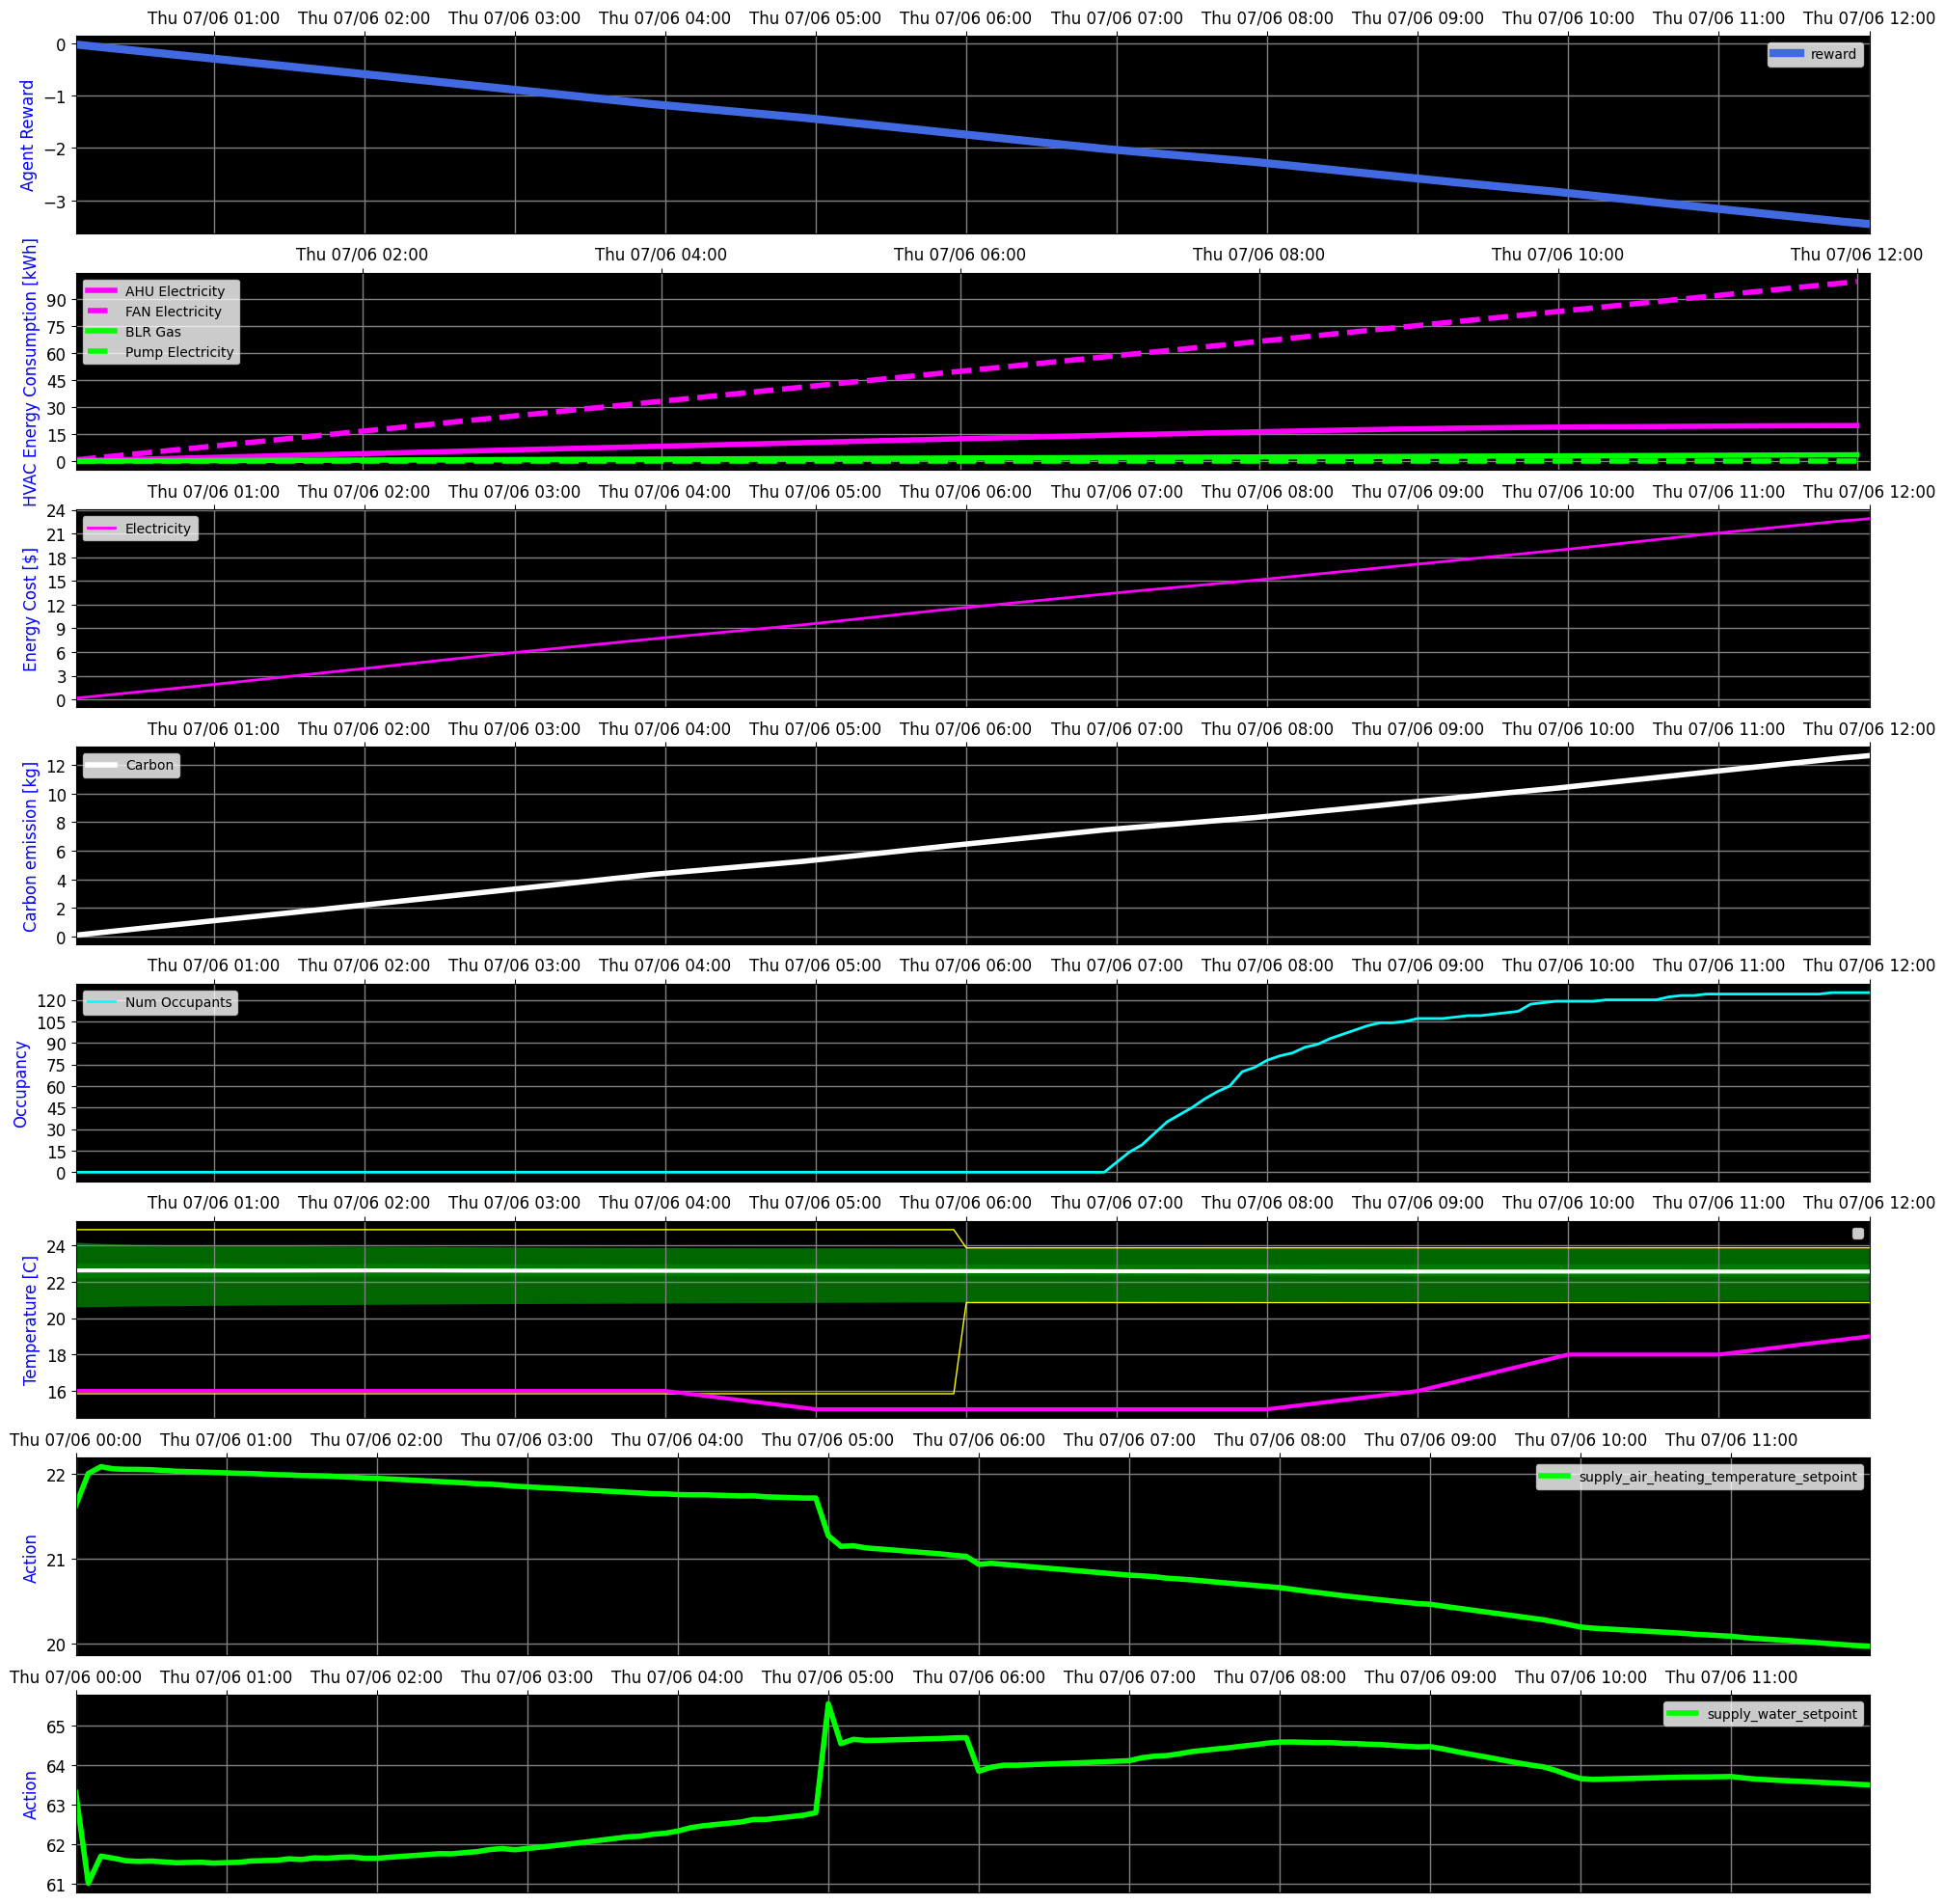

KeyboardInterrupt: 

In [33]:
# @title Execute the training loop

num_training_iterations = 10
num_gradient_updates_per_training_iteration = 100

# Collect the performance results with teh untrained model.
#eval_actor.run_and_log()

logging_info('Training.')

# @title Modified Training Loop with World Model
# Initialize world model
state_dim = collect_env.observation_spec().shape[0]
action_dim = collect_env.action_spec().shape[0]
world_model = WorldModel(state_dim, action_dim)

for iter in range(num_training_iterations):
    print('Training iteration: ', iter)
    
    # Collect real experiences
    #collect_actor.run()
    
    # Train world model
    train_world_model(world_model, reverb_replay)
    
    # Generate synthetic experiences
    initial_state = ts.observation
    initial_reward = ts.reward
    initial_discount = ts.discount
    # synthetic_trajectories = generate_synthetic_experiences(
    #     world_model, initial_state, collect_policy)
    
    # # Add synthetic experiences to replay buffer
    # for traj in synthetic_trajectories:
    #     rb_observer(traj)
    
    synthetic_rollouts = generate_rollouts(world_model, initial_state, 
                                            initial_reward, initial_discount, collect_policy)
    for exp in synthetic_rollouts:
        add_to_replay_buffer(rb_observer, exp)
        # rb_observer(trajectory.from_episode(
        #     observation=exp['state'],
        #     action=exp['action'],
        #     policy_info=(),
        #     reward=exp['reward'],
        #     discount=exp['discount']
        # ))
        

    # Train agent with both real and synthetic data
    loss_info = agent_learner.run(
        iterations=num_gradient_updates_per_training_iteration)
    
    logging_info(
        'Actor Loss: %6.2f, Critic Loss: %6.2f, Alpha Loss: %6.2f '
        % (
            loss_info.extra.actor_loss.numpy(),
            loss_info.extra.critic_loss.numpy(),
            loss_info.extra.alpha_loss.numpy(),
        )
    )
    
    # Evaluate
    eval_actor.run_and_log()